# Production Quality Prediction

**Context<br>**
You need to build a model that, on the basis of data arriving every minute, determines the quality of products produced on a roasting machine. <br>

**Content<br>**
The roasting machine is an aggregate consisting of 5 chambers of equal size, each chamber has 3 temperature sensors. In addition, for this task, you have collected data on the height of the raw material layer and its moisture content. Layer height and humidity are measured when raw materials enter the machine. Raw materials pass through the kiln in an hour.<br>

**Acknowledgements<br>**
Product quality is measured in the laboratory by samples that are taken every hour, data on known analyzes are contained in the file data_Y.csv. The file indicates the time of sampling, the sample is taken at the exit of the roasting machine.<br>

**Inspiration<br>**
You agreed with the customer that the model will be estimated by the MAE indicator, to evaluate the model, it is necessary to generate predictions for the period specified in the file sample_submission.csv (5808 predictions).<br>

**Notebook Author** <br>
**Aleksander Jakubowski**

#### Example of Roasting machine 
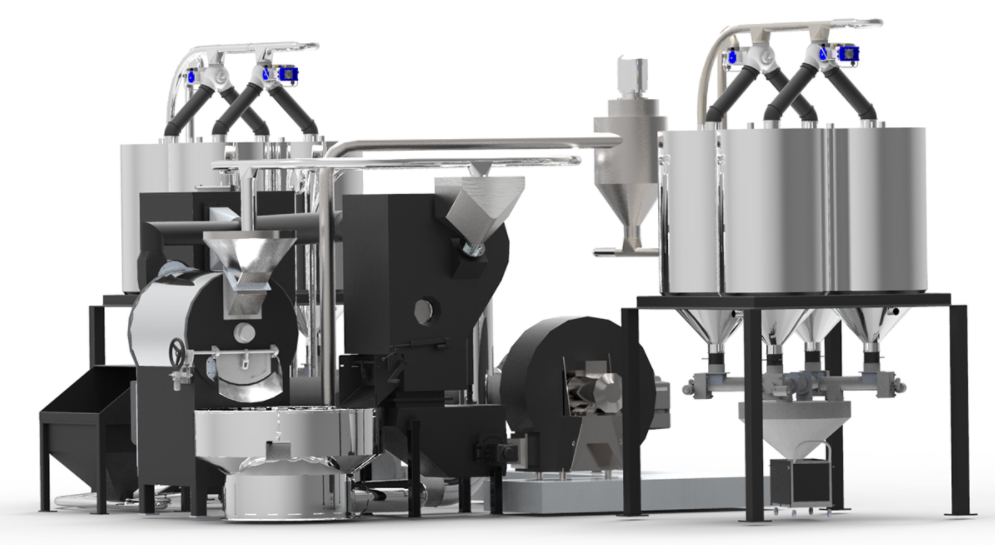

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


import os


In [ ]:
X = pd.read_csv("/kaggle/input/production-quality/data_X.csv")
submission = pd.read_csv("/kaggle/input/production-quality/sample_submission.csv")
Y = pd.read_csv("/kaggle/input/production-quality/data_Y.csv")

## So what we know and what can we assume?

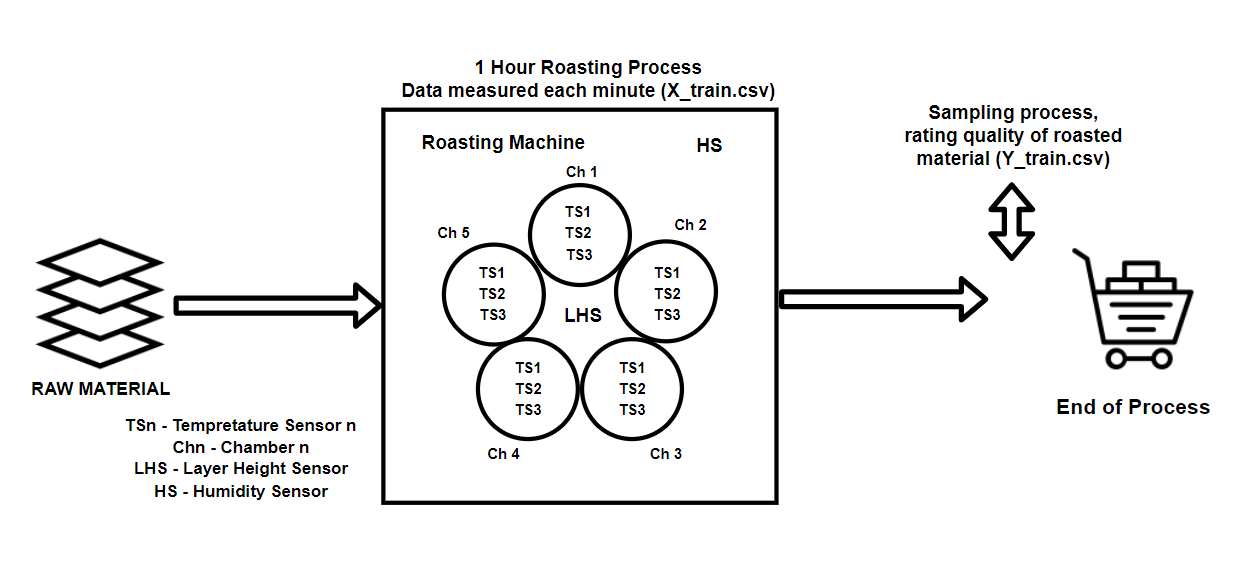

We have machine with 5 chambers (Chn) and each chambler has got 3 temperature sensors (TSn) and there are also humidity senors (HS) and layer height sensor (LHS).
I can pressume that temperatures can affect roasting (overroast and underroast). <br>
3 Sensors are probably located in different spots of chamber to ensure proper temperature in each part of chamber and ultimately even roasting of material.<br>
Humidity is probably there to indicate required environment to roast material.<br>
Layer height is more of a volume information. We can can assume that volume can affect roasting, also layer might be good indicator when material was changed.<br>

Since entire process takes about 1 hour and seeds are sampled every hour. We can assume that quality of material sampled refers to measurements from previous hour.<br>

As for the measurements it is very difficult to assign one target variable to entire hour of measurements.
If we assign one value to all measurements we will literally have good conditions that show possibly lower quality material and it will amount to nothing while building model. <br>
In order to show entire hour of quality measurements I would suggest to transpose our data a little bit and get something that I would call process matrix (or table). Basically each minute of measurement would be a set of columns that make up one very high dimensional row. This would increase dimension of our data quite significantly (16 columns * 60 minutes). <br>
Our single sample would have around 960 columns + layer height column as layer is very likely to stay the same. In order to decrease dimension of our dataset we can go machine learning route with PCA or tSNE... or we can also get average chamber temperature for each minute. However I wouldnt recommend doing anything of that, its better to leave data as it is for now.<br>

As for modeling. In my experience a lot of these problems were solved using Decision Trees or Gradient Boosting methods (see [Bosch Production Line Performance](https://www.kaggle.com/c/bosch-production-line-performance)). In that case I will pick XGBoost Regression model as my base and I will compare it to Sklearn DecisionTree Regressor.




In [ ]:
X["date_time"]=pd.to_datetime(X["date_time"])
X["date_hour"] = X["date_time"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))

In [ ]:
X

## Process DataFrame
So generally I commented this code out because it exceeds Kaggle notebook time limits. I downloaded data required in this transformation and did it locally on my computer. Feel free to uncomment this and use it, however it may take longer than 9hours. If you find way to do it more efficiently, please let me know.

In [ ]:
# df = pd.DataFrame()
# for date_hour in list(X.date_hour.unique()):
#     temp = X.loc[X.date_hour==date_hour]
#     ah = list(temp["AH_data"].unique())[0]
#     temp = temp[temp.columns[1:]]
#     temp = pd.DataFrame(temp.set_index(["date_hour","AH_data"]).stack()).reset_index()[["level_2",0]].T.drop(["level_2"])
#     temp["date_hour"]= date_hour
#     temp["AH_data"]=ah
#     df = pd.concat([df,temp])

In [ ]:
df = pd.read_csv("/kaggle/input/training-frame/training_frame.csv")
df

df is our transformed dataset. We can extract our training input and our submission input using date_hour.

In [ ]:
Y["date_shifted"] = pd.to_datetime(Y["date_time"]) - datetime.timedelta(hours=1)
Y["date_shifted"] = pd.to_datetime(Y["date_shifted"])
Y["date_shifted"] = Y["date_shifted"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))

In [ ]:
training = pd.merge(df,Y[["date_shifted","quality"]],left_on="date_hour",right_on="date_shifted",how="inner")

In [ ]:
submission["date_hour"] = pd.to_datetime(submission["date_time"]).apply(lambda x: x.strftime("%d-%m-%Y-%H"))
validation = pd.merge(df,submission[["date_hour","quality"]],left_on="date_hour",right_on="date_hour",how="inner")

In [ ]:
training

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
dt_model = DecisionTreeRegressor(random_state=0)
X_val = training.drop(["date_hour","date_shifted","quality"],axis=1)
y_val = training["quality"]

To check how well model performs overall I will use cross-validation. 

In [ ]:
xgb_cv =cross_val_score(xgb_model,X_val,y_val,cv=10,scoring=('neg_mean_absolute_error'))

In [ ]:
print("Average XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.mean())))
print("Best XGB Cross Validation MAE: {0}".format(np.abs(xgb_cv.max())))

In [ ]:
cv_dt = cross_val_score(dt_model,X_val,y_val,cv=5,scoring=('neg_mean_absolute_error'))

In [ ]:
print("Average Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.mean())))
print("Best Decision Tree Cross Validation MAE: {0}".format(np.abs(cv_dt.max())))

So after cross validation I can see that XGB performs better than DecisionTrees. I wouldn't assume that MAE = 7.012 is our final result as we used 90% of training data to train models, so we still can have a little bit more than that.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=0)

In [ ]:
dt_model.fit(X_train,y_train)

In [ ]:
xgb_model.fit(X_train,y_train)

In [ ]:
predictions_xgb = xgb_model.predict(X_test)
predictions_dt = dt_model.predict(X_test)

In [ ]:
print("XGBoost Regressor MAE: {0}".format(mean_absolute_error(y_test,predictions_xgb)))
print("DecisionTree Regressor MAE: {0}".format(mean_absolute_error(y_test,predictions_dt)))

Here we can see that MAE is sitting at 6.954.

In [ ]:
results = pd.DataFrame()
results["True"] = y_test
results["Predicted XGB"]=predictions_xgb
results["Predicted DecisionTree"]=predictions_dt

In [ ]:
results

## Submission file

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_val,y_val)

In [ ]:
validation = validation.drop(["date_hour","quality"],axis=1)

In [ ]:
quality = model.predict(validation)
submission["quality"]=quality

In [ ]:
submission = submission[["date_time","quality"]]

In [ ]:
submission

## SUMMARY
The best value on metrics we have achieved was MAE = 6.954. To improve upon this value we would need to work with GridSearch to get better parameters from our XGB Regression model. 
Preprocessing was quite limited since we didn't have any missing values and XGB doesn't require feature scalling or normalization (it can deal with null values too).

In the end the key to achiving good value is to pass entire process (1h of measurements) as single row since we do not know at which point process is losing its quality so we need to compare process as whole. This requires quite extensive transformation (if someone has way to do it faster than 9h, I would really love to know it).

Perhaps someone could say why didn't I checked correlations between each feature and target variables to see if prediction is even possible and that would be correct assuption however in industrial problems I believe that engineering (and domain) knowledge are much more important, especially since there is so many features across entire manufacturing process (it would be hard to check if those are affecting quality).

